In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import gzip
import numpy as np
import pandas as pd
from collections import namedtuple

Feature = namedtuple('Feature', ['id',
                                 'ftype',
                                 'chromosome',
                                 'start',
                                 'end',
                                 'strand',
                                 'gene',
                                 'product'])

def parse_gff(file_name):
    # output dict
    # key: feature ID
    # value: Feature NamedTuple
    features = {}

    with gzip.open(file_name, 'rt') as gff:
        for line in gff:
            if line.lstrip().startswith('##FASTA'):
                # start of FASTA entries, end of file
                break

            elif line.lstrip().startswith('#'):
                # comment, ignore
                continue

            # should be a valid GFF3 line
            entries = line.split('\t')

            try:
                ftype = entries[2]

                chrom = entries[0]
                start = int(entries[3])
                end = int(entries[4])
                strand = entries[6]

                # integer takes up less space
                if strand == '+':
                    strand = 1
                else:
                    strand = -1

                # fetch the feature ID from the last field
                ID = None
                for entry in entries[8].split(';'):
                    if entry.startswith('ID=') and '=' in entry:
                        ID = entry.split('=')[1]

                # could not find it, skip this entry
                if ID is None:
                    continue

                # fetch the gene name
                gene = np.nan
                for entry in entries[8].split(';'):
                    if entry.startswith('gene=') and '=' in entry:
                        gene = entry.split('=')[1]

                product = np.nan
                for entry in entries[8].split(';'):
                    if entry.startswith('product=') and '=' in entry:
                        product = entry.split('=')[1]

                # save the relevant details
                features[ID] = Feature(ID, ftype, chrom, start, end, strand, gene, product)

            except Exception as e:
                # not distinguishing between exceptions
                # not great behaviour
                logger.warning(f'{e}, skipping line "{line.rstrip()}" from {file_name}')
                continue

    return features

features = parse_gff('../data/GCF_009858895.2_ASM985889v3_genomic.gff.gz')

res = []
for feat in features.values():
    for i, position in enumerate(range(feat.start, feat.end+1)):
        res.append( (feat.chromosome, feat.ftype, position, i+1, feat.strand, feat.id, feat.gene, feat.product) )
r = pd.DataFrame(res,
                 columns=['chromosome', 'ftype', 'position', 'feature_position', 'strand', 'id', 'gene', 'product'])


In [3]:
r[r['ftype'] == 'CDS'].groupby('gene')['feature_position'].max().to_dict()

{'E': 228,
 'M': 669,
 'N': 1260,
 'ORF10': 117,
 'ORF1ab': 13218,
 'ORF3a': 828,
 'ORF6': 186,
 'ORF7a': 366,
 'ORF7b': 132,
 'ORF8': 366,
 'S': 3822}

In [4]:
gpos = r[r['ftype'] == 'CDS'].groupby('gene').apply(
    lambda x: pd.Series([x['position'].min(), x['position'].max()],
                        index=['start', 'stop'])).sort_values('start')

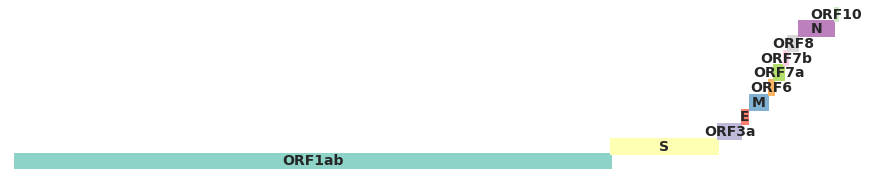

In [12]:
fig, ax = plt.subplots(figsize=(15, 3))

for i, (color, (g, (start, stop))) in enumerate(zip(sns.color_palette('Set3', gpos.shape[0]),
                                                    gpos.iterrows())):
    rect = patches.Rectangle((start, i), stop-start, 1, linewidth=2, edgecolor=color, facecolor=color)
    ax.add_patch(rect)
    ax.text((stop+start) / 2, i+0.5,
            g,
            ha='center',
            va='center',
            weight='bold',
            fontsize=14)

ax.set_xlim(0, 29903)
ax.set_ylim(-0.1, i+1)

ax.set_yticks([])
ax.set_xticks([])

sns.despine(left=True, bottom=True)

plt.savefig('genes.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('genes.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);